Иморитирование всех необходимых библиотек

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Смотрим исходные данные

In [82]:
train = pd.read_csv("df/train.csv", low_memory=False)
valid = pd.read_csv("df/valid.csv", low_memory=False)

arr = [train, valid]
names_df = ['train', 'valid']

for i, elem in enumerate(arr):
      print(f"Число пропущенных значений в датасете {names_df[i]}:")
      print(elem.isna().sum())
      if i == 0:
            print("\n")

for i, elem in enumerate(arr):
    print(f"\nДатасет {names_df[i]} имеет: {elem.shape}")

Число пропущенных значений в датасете train:
report_date        0
client_id          0
target             0
col1           14453
col2           14450
               ...  
col2659        13950
col2660         6420
col2661         6420
col2662         6420
col2663            0
Length: 2666, dtype: int64


Число пропущенных значений в датасете valid:
report_date       0
client_id         0
target            0
col1           3642
col2           3640
               ... 
col2659        3578
col2660        1280
col2661        1280
col2662        1280
col2663           0
Length: 2666, dtype: int64

Датасет train имеет: (14456, 2666)

Датасет valid имеет: (3642, 2666)


Визуализируем, сколько пропущенных значений в DataFrame.

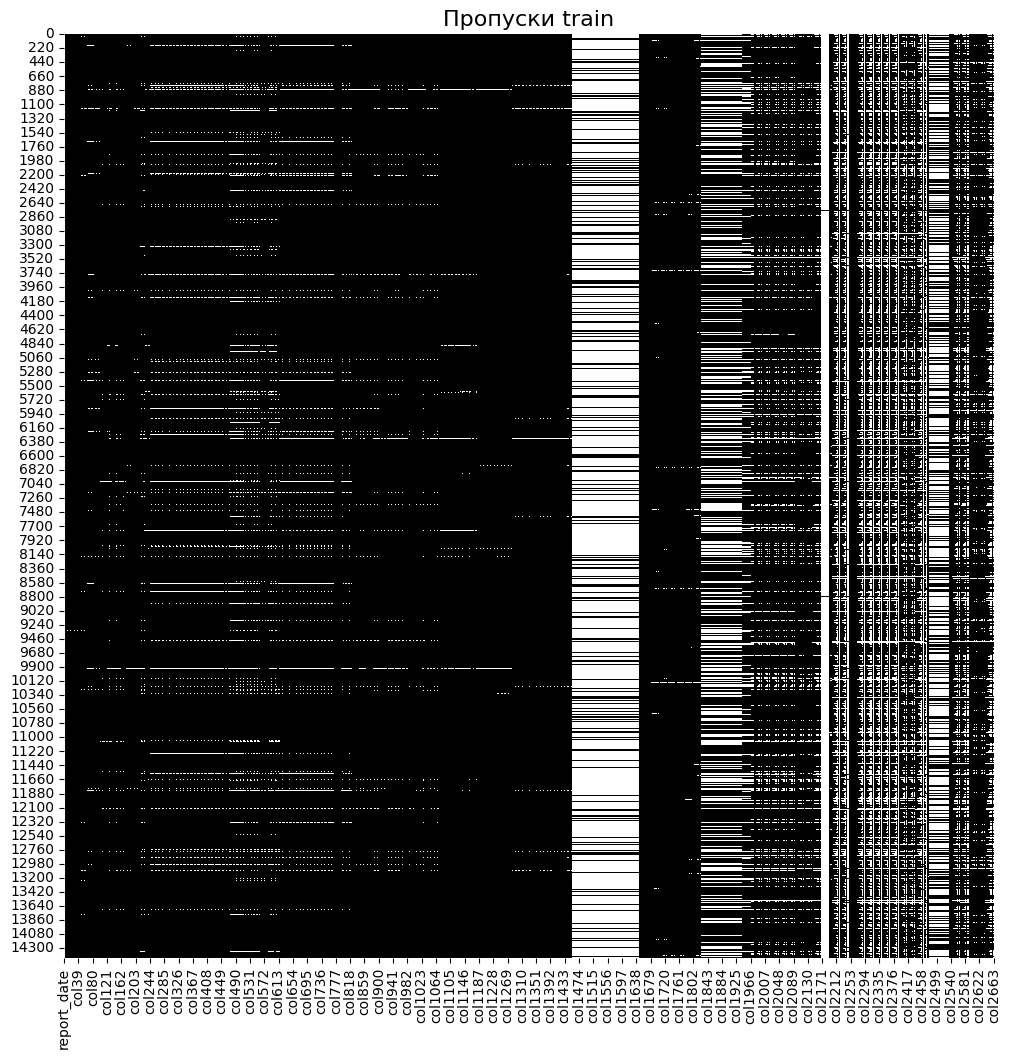

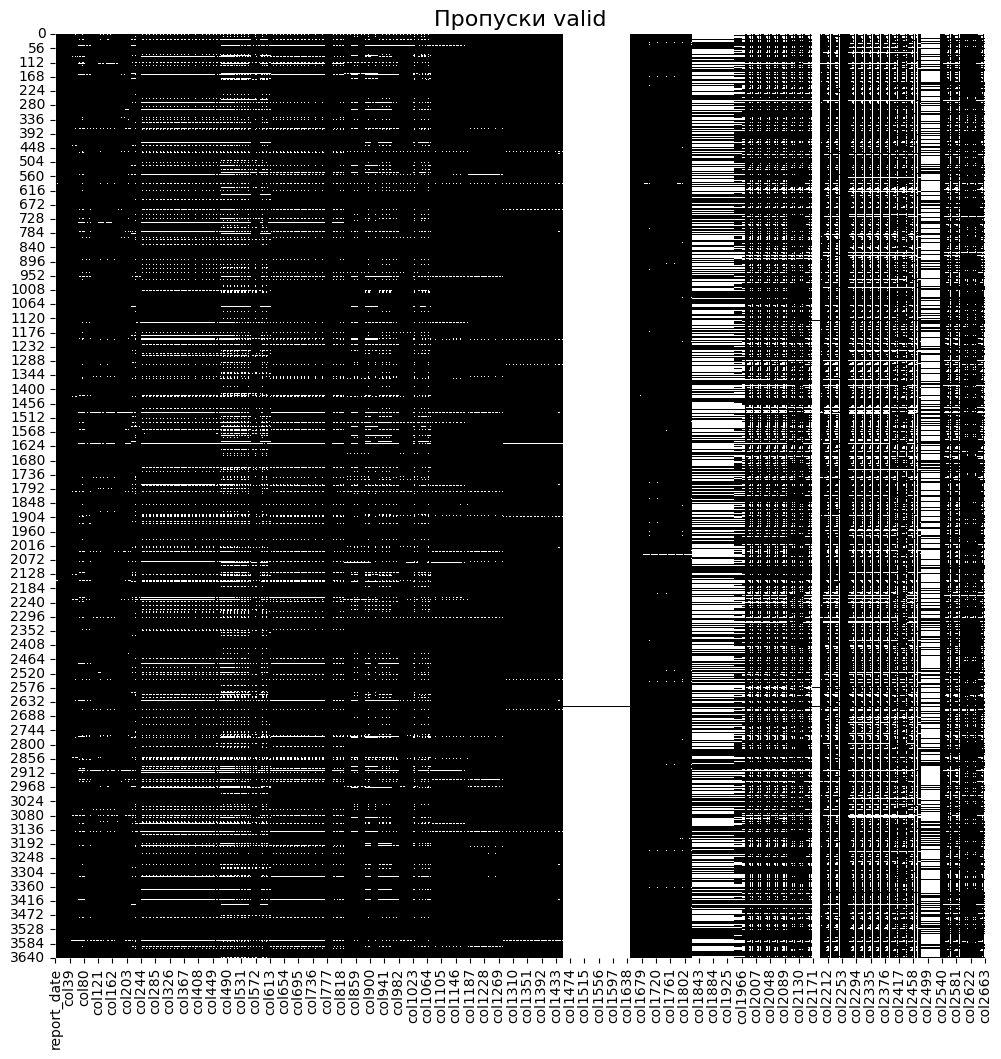

In [83]:
for i, elem in enumerate(arr): 
      fig, ax = plt.subplots(figsize=(12, 12))
      sns.heatmap(elem.isnull(), cbar = False, cmap = 'Greys')
      plt.title(f"Пропуски {names_df[i]}", fontsize=16)
      plt.show()

Обработка 

In [84]:
for i, elem in enumerate(arr):
    elem.drop_duplicates(inplace=True, subset=["client_id"]) # дубликаты

    threshold_col = 0.75 * len(elem) # Удаление столбцов, где менее 75% значений присутствуют
    elem.dropna(axis=1, thresh=threshold_col, inplace=True)

    threshold_row = 0.75 * len(elem.columns)  # Удаление строк, где менее 75% значений присутствуют
    elem.dropna(thresh=threshold_row, inplace=True)

    # Заполнение пропусков медианой только для числовых столбцов
    numeric_cols = elem.select_dtypes(include=['number']).columns
    if not numeric_cols.empty:  # Проверка, есть ли числовые столбцы
        elem.loc[:, numeric_cols] = elem[numeric_cols].fillna(elem[numeric_cols].median())
    # df.loc потому что это срез оригинала df

    # Удаление строк с NaN только в текстовых столбцах
    string_cols = elem.select_dtypes(include=['object']).columns
    if not string_cols.empty:  # Проверка, есть ли строковые столбцы
        elem.dropna(subset=string_cols, inplace=True)

Проверяем значения после обработки

In [85]:
for i, elem in enumerate(arr):
      print(f"Число пропущенных значений в датасете {names_df[i]} после обработки:")
      print(elem.isna().sum())
      if i == 0:
            print("\n")

for i, elem in enumerate(arr):
    print(f"\nДатасет {names_df[i]} после обработки имеет: {elem.shape}")

Число пропущенных значений в датасете train после обработки:
report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2460        0
col2461        0
col2462        0
col2470        0
col2663        0
Length: 262, dtype: int64


Число пропущенных значений в датасете valid после обработки:
report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2460        0
col2461        0
col2462        0
col2470        0
col2663        0
Length: 247, dtype: int64

Датасет train после обработки имеет: (4020, 262)

Датасет valid после обработки имеет: (2931, 247)


In [86]:
# Т.к. кол-во столбцов отличается в df-ах оставим только те которые есть в обоих df
common_columns = list(set(train.columns).intersection(set(valid.columns)))

# Оставляем только общие столбцы в обоих датафреймах
train_cleaned = train[common_columns]
valid_cleaned = valid[common_columns]

arr_cleaned = [train_cleaned, valid_cleaned]

# Проверяем, совпадают ли структуры после дополнительной чистки
if sorted(train_cleaned.columns) != sorted(valid_cleaned.columns):
    raise ValueError("Структуры train и valid не совпадают!")
else:
    print("Структуры train и valid совпадают.")

for i, elem in enumerate(arr_cleaned):
    print(f"\nДатасет {names_df[i]} после обработки имеет: {elem.shape}")

# Сохраняем обработанные данные в новые файлы
train_cleaned.to_csv('df/_train_updt.csv', index=False)
valid_cleaned.to_csv('df/_valid_updt.csv', index=False)
print("\nОбработанные датасеты сохранены.")

Структуры train и valid совпадают.

Датасет train после обработки имеет: (4020, 247)

Датасет valid после обработки имеет: (2931, 247)

Обработанные датасеты сохранены.


Визуализация, сколько пропущенных значений в DataFrame.

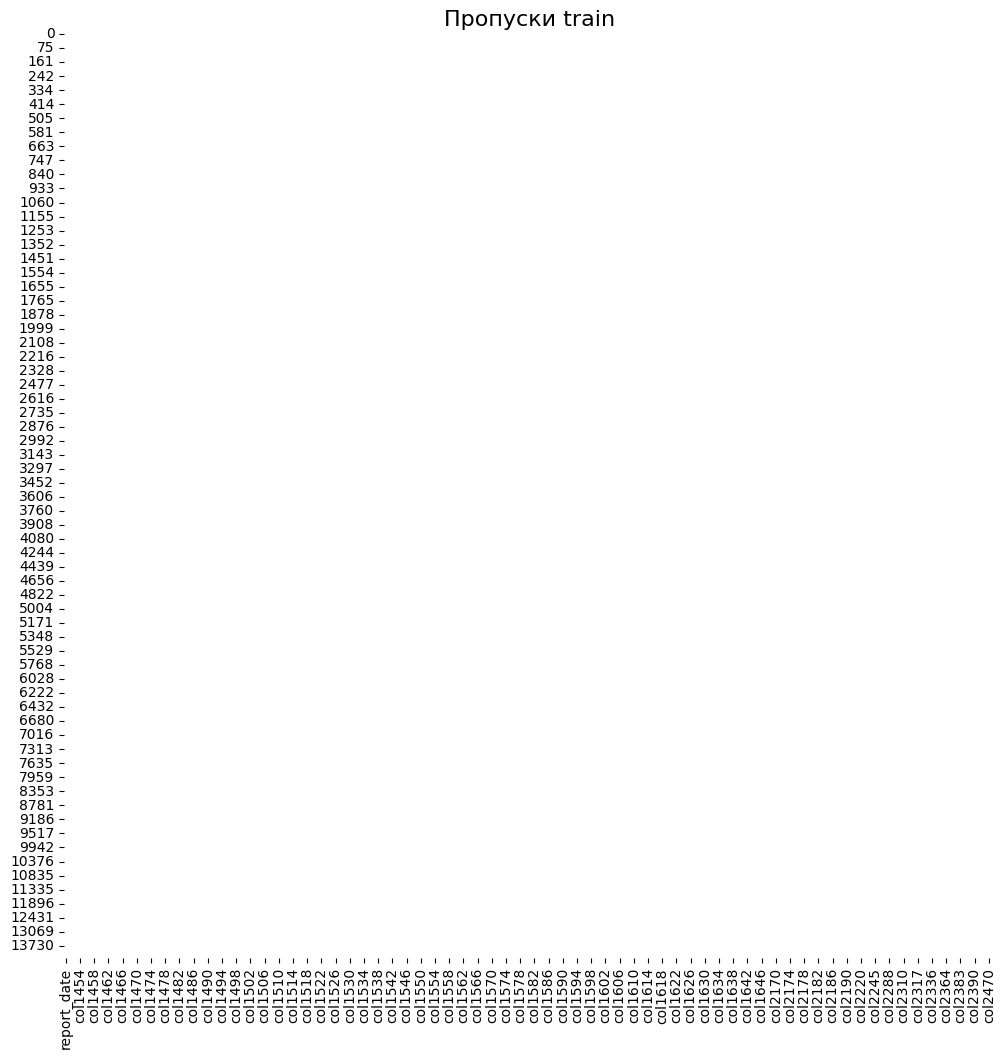

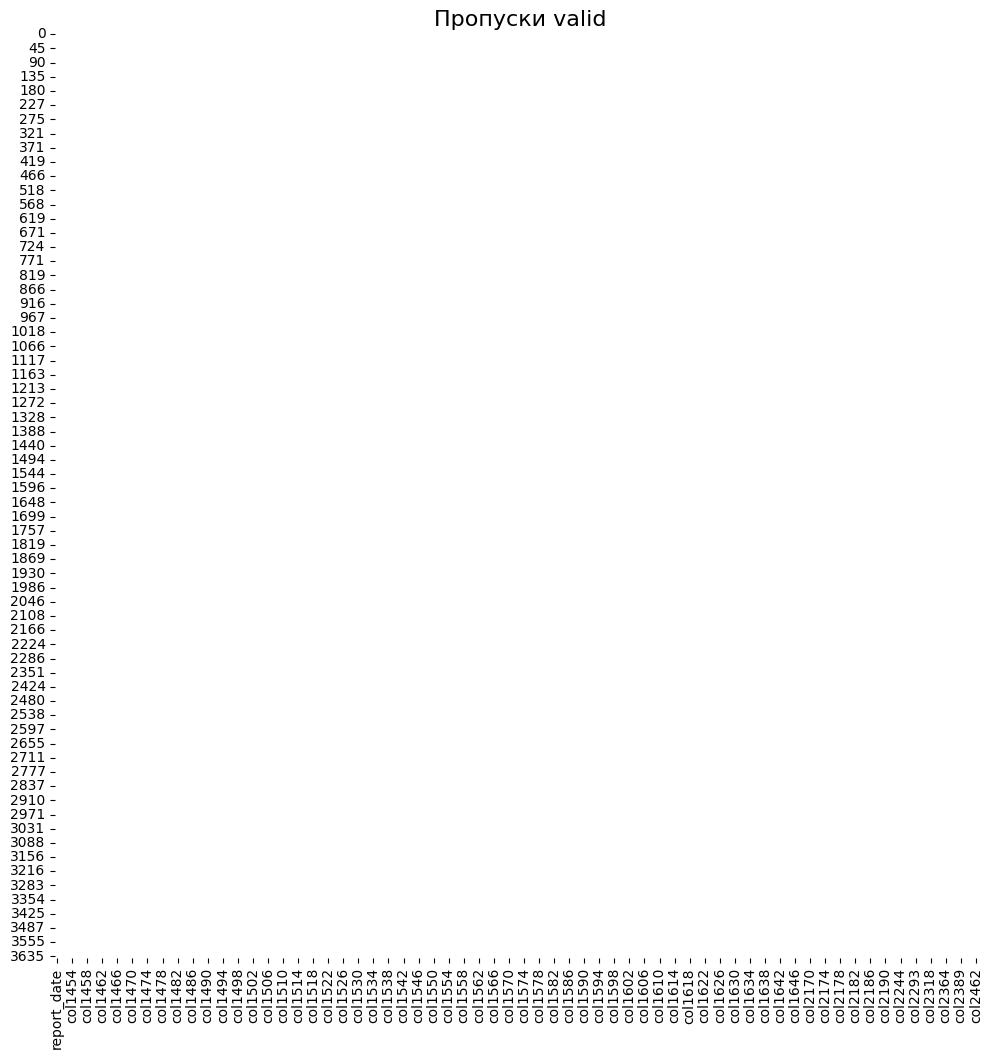

In [87]:
for i, elem in enumerate(arr): 
      fig, ax = plt.subplots(figsize=(12, 12))
      sns.heatmap(elem.isnull(), cbar = False, cmap = 'Greys')
      plt.title(f"Пропуски {['train', 'valid'][i]}", fontsize=16)
      plt.show()

Модель

In [88]:
# Преобразование категориальных переменных
df = pd.get_dummies(train, drop_first=True)

# Разделение признаков и целевой переменной
X = df.drop(columns=['target'])
y = df['target']